In [6]:
%cd /content/drive/MyDrive/Colab Notebooks/sprint24

/content/drive/MyDrive/Colab Notebooks/sprint24


In [10]:
'''Sequence to sequence example in Keras (character-level).

This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.

# Summary of the algorithm:

- We start with input sequences from a domain (e.g. English sentences)
    and correspding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    Is uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.

# Data download:

English to French sentence pairs.
https://www.manythings.org/anki/fra-eng.zip

Lots of neat sentence pairs datasets can be found at:
https://www.manythings.org/anki/

# References:

- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.1078
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
lines = open(data_path, encoding="utf-8").read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)


Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Epoch 1/100
125/125 [==============================] - 11s 43ms/step - loss: 0.9716 - val_loss: 1.0686
Epoch 2/100
125/125 [==============================] - 4s 33ms/step - loss: 0.9009 - val_loss: 0.9991
Epoch 3/100
125/125 [==============================] - 4s 33ms/step - loss: 0.8526 - val_loss: 1.0145
Epoch 4/100
125/125 [==============================] - 4s 33ms/step - loss: 0.8158 - val_loss: 0.9496
Epoch 5/100
125/125 [==============================] - 4s 33ms/step - loss: 0.7849 - val_loss: 0.8896
Epoch 6/100
125/125 [==============================] - 4s 33ms/step - loss: 0.7630 - val_loss: 0.8584
Epoch 7/100
125/125 [==============================] - 4s 33ms/step - loss: 0.7417 - val_loss: 0.8259
Epoch 8/100
125/125 [==============================] - 4s 33ms/step - loss: 0.7227 - val_loss: 0.8065
Epoch 9/100
125/12

In [5]:
!pwd

/content/drive/MyDrive/Colab Notebooks/sprint24


In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/sprint24

/content/drive/MyDrive/Colab Notebooks/sprint24


## 【問題1】機械翻訳の実行とコードリーディング
---
以下のサンプルコードは、短い英語からフランス語への変換を行うものです。これを動かしてください。

keras/lstm_seq2seq.py at master · rstudio/keras

その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。

### コードリーディング


    51から55行目 : ライブラリのimport
    57から62行目 : ハイパーパラメータの設定
    65から82行目 : 外部テキストファイルを読み込み、リスト化
    84から89行目 : リスト化されたデータ情報からエンコーダーとデコーダー用の変数を定義
    91から95行目 : 定義したエンコーダーとデコーダー用の変数をプリントアウトして確認
    97から110行目 : 上記の変数をゼロで初期化
    112から121行目 : 外部ファイルから読み込んだデータを元に入力トークンとそのインデックス、
    　　　　　　　　 ターゲットトークンとそのインデックスの値を準備した変数に格納。
    123から128行目 : 入力シーケンスとLSTMモデルを用いてエンコーダーのプロセスを定義
    130から139行目 : 入力シーケンスとLSTMモデルを用いてデコーダーーのプロセスを定義
    　　　　　　　　 デコーダーの勾配処理の活性化関数はSoftmaxを使用
    143行目 : 実行するモデルを定義
    145から150行目 : モデルの学習を実行。最適化としてrmsPropを使用し、損失関数はcategorical_crossentropyを使用
    152行目 : 学習たモデルをs2s.h5”として保存
    163行目 : サンプリング用モデルを定義
    165から174行目 : デコーダーのステータス、モデルなどを定義
	178から181行目 : シーケンスをデコードして読み取り可能なものに戻すための逆ルックアップトークンインデックスを作成
	184から219行目 : decode_sequence関数の定義。入力シーケンスを引数、戻り値はデコーダーされた文章。
	222から229行目 : エンコーダーの入力データを一つずつ取り出し、デコーダー処理をした結果をプリントアウトしている。
	　　　　　　　　 これを100回繰り返している。
	
	


## 【問題2】イメージキャプショニングの学習済みモデルの実行
---
上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。

データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。

注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [11]:
!pwd

/content/drive/MyDrive/Colab Notebooks/sprint24


In [10]:
%cd /content/drive/MyDrive/Colab Notebooks/sprint24

/content/drive/MyDrive/Colab Notebooks/sprint24


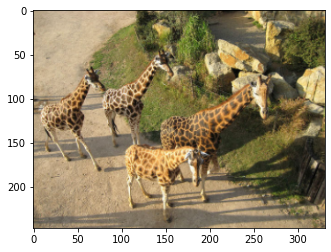

In [13]:
import matplotlib.pyplot as plt
img = plt.imread(r'png/example.png')
plt.imshow(img)
plt.show()

In [12]:
!python sample.py --image='png/example.png'

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100% 230M/230M [00:03<00:00, 71.6MB/s]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<start> a group of giraffes standing next to each other . <end>


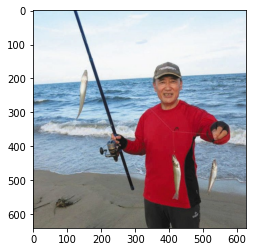

In [14]:
img = plt.imread(r'png/pic1.png')
plt.imshow(img)
plt.show()

In [15]:
!python sample.py --image='png/pic1.png'

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<start> a man holding a surfboard in the ocean . <end>


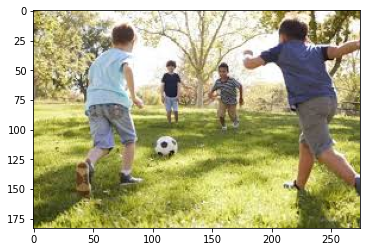

In [16]:
img = plt.imread(r'png/pic2.png')
plt.imshow(img)
plt.show()

In [17]:
!python sample.py --image='png/pic2.png'

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<start> a group of people playing a game of frisbee . <end>


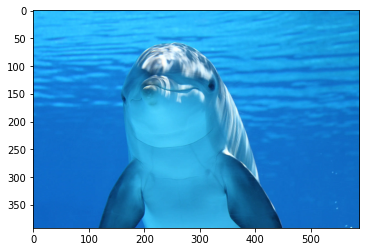

In [18]:
img = plt.imread(r'png/pic3.png')
plt.imshow(img)
plt.show()

In [20]:
!python sample.py --image='png/pic3.png'

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<start> a white dog is standing in the water . <end>


## 【問題3】Kerasで動かしたい場合はどうするかを調査
---
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。

特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

### 回答
---

PyTorchはpklファイルを直接読み込むことができるが、Kerasはそのようなモジュールがないのでpickleライブラリでpickleファイルを読み込むようにする。


学習済みモデルを読み込むために
sample.pyファイルの43～44行目のところを下記に置き換える。

```
with open(args.encoder_path, 'rb') as f:
  encoder_file = pickle.load(f)
  encoder.load_state_dict(encoder_file)

with open(args.decoder_path, 'rb') as f:
  decoder_file = pickle.load(f)
  decoder.load_state_dict(decoder_file)
```